# CDS540 Assignment 1 - Text Detection from Images Using OpenCV

## 1. Setup Environment

In [9]:
%pip install opencv-python imutils pytesseract

Note: you may need to restart the kernel to use updated packages.


## 2. Load an Image

For windows users, we need to specify the `tesseract` path. By settings this:
```python
pytesseract.pytesseract.tesseract_cmd = <YOUR_PATH>
```
We can extract the text with the `tesseract`. But we need to ensure the `tesseract` is installed, the installer can be found at [this URL](https://github.com/UB-Mannheim/tesseract/wiki)

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import math
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\shiku\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

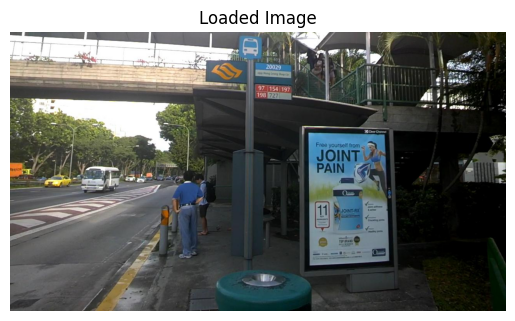

In [11]:
img = cv2.imread(r"imgs\img_2.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Loaded Image")
plt.show()

In [12]:
def show_image(img: np.ndarray,title:str):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

## 3.	Pre-process the Image:
1. To gray scale.
2. Apply Gaussian Blur to remove noise.

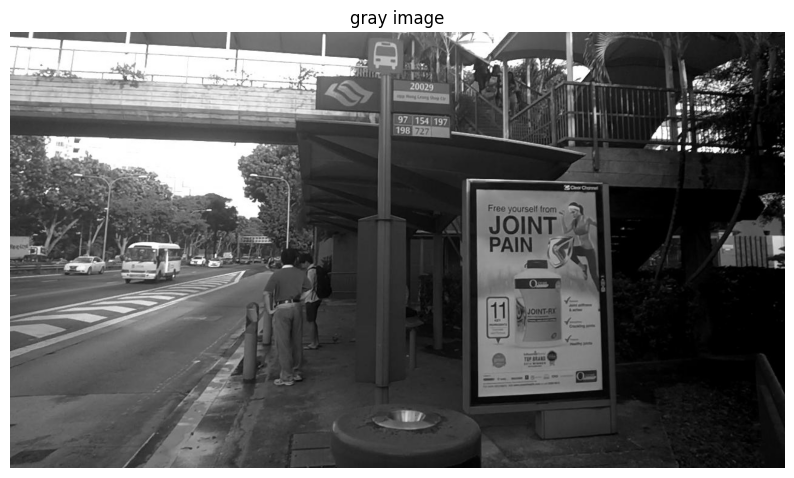

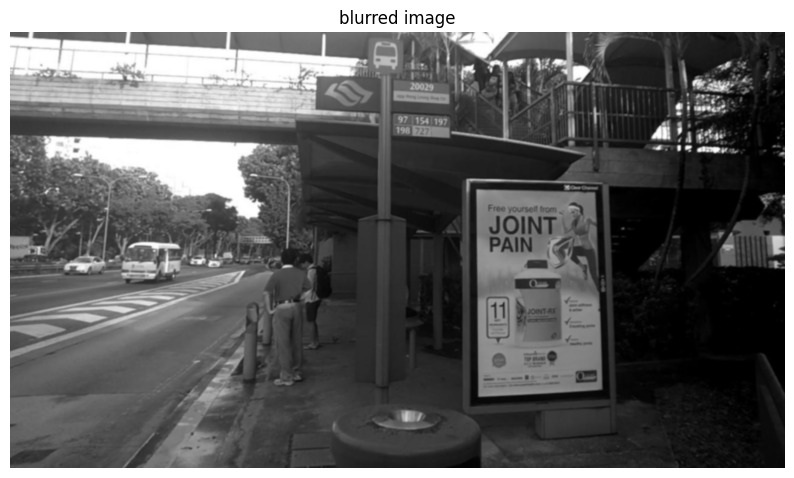

In [13]:
# Step 2: Pre-process the Image
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray,"gray image")
# Apply Gaussian Blurring to remove noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
show_image(blurred,"blurred image")
img = cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB)

## 4.	Text Detection:

1. load EAST model
2. Decode the bounding boxes from the model


In [14]:
east_model = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model)

# Prepare the input image for EAST text detector
(h, w) = img.shape[:2]
newW, newH = (320, 320)
rW = w / float(newW)
rH = h / float(newH)

blob = cv2.dnn.blobFromImage(img, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)

# Define the output layers of EAST
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

(scores, geometry) = net.forward(layerNames)


In [15]:
scores.shape

(1, 1, 80, 80)

In [16]:
geometry.shape

(1, 5, 80, 80)

## 5.	Extract and Display Text:

In [17]:
# Decode bounding boxes from the output of the EAST model
def decode_predictions(scores:np.ndarray, geometry:np.ndarray, confThreshold:int=0.5)->tuple[list,list]:
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        
        for x in range(0, numCols):
            if scoresData[x] < confThreshold:
                continue
            
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
    return (rects, confidences)

from imutils.object_detection import non_max_suppression
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

# Draw the bounding boxes on the image
for (startX, startY, endX, endY) in boxes:
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)

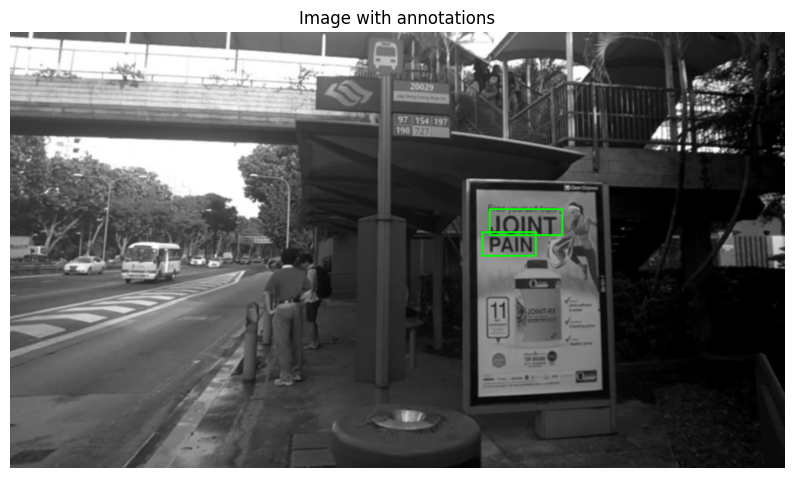

In [19]:
show_image(img,"Image with annotations")


## 6.	Efficiency and Effectiveness Evaluation:

In [34]:
# Wrap the above procedures as a function
def detect_and_extract_text(image_path:str, net:cv2.dnn.Net, output_folder:str)->np.ndarray:
    # Step 1: Load an Image
    image = cv2.imread(image_path)

    # Step 2: Pre-process the Image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.cvtColor(cv2.GaussianBlur(gray, (5, 5), 0), cv2.COLOR_GRAY2RGB)

    # Step 3: Text Detection using EAST Detector
    (h, w) = image.shape[:2]
    newW, newH = (320, 320)
    rW = w / float(newW)
    rH = h / float(newH)

    blob = cv2.dnn.blobFromImage(blurred, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    (scores, geometry) = net.forward(layerNames)

    # Decode bounding boxes from the output of the EAST model
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Draw the bounding boxes on the image
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # Step 4: Extract Text
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    extracted_text = pytesseract.image_to_string(rgb)
    print(f"Extracted Text from {image_path}:")
    print(extracted_text)

    # Step 5: Save Annotated Image
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, image)

    return image

In [35]:
input_folder = "imgs"
output_folder = "annotated_imgs"
os.makedirs(output_folder, exist_ok=True)

Extracted Text from imgs\img_138.jpg:

Extracted Text from imgs\img_139.jpg:

Extracted Text from imgs\img_140.jpg:

Extracted Text from imgs\img_143.jpg:

Extracted Text from imgs\img_153.jpg:
~ we

Extracted Text from imgs\img_2.jpg:

Extracted Text from imgs\img_26.jpg:
2
fi
B=
oS
Lo
my
2
a
3
ie
=


Extracted Text from imgs\img_436.jpg:
eee iy

—
Dp
od Pela
rn


Extracted Text from imgs\img_441.jpg:

Extracted Text from imgs\img_454.jpg:

Extracted Text from imgs\img_457.jpg:

Extracted Text from imgs\img_463.jpg:

Extracted Text from imgs\img_466.jpg:

Extracted Text from imgs\img_47.jpg:

Extracted Text from imgs\img_476.jpg:

Extracted Text from imgs\img_482.jpg:

Extracted Text from imgs\img_74.jpg:

Extracted Text from imgs\img_99.jpg:
x J

A 8
gee” *
~ ee I | Spal
YS iis). SA inn re
ti al t
Vi gli : "1 |

git fag mon
5 as
om




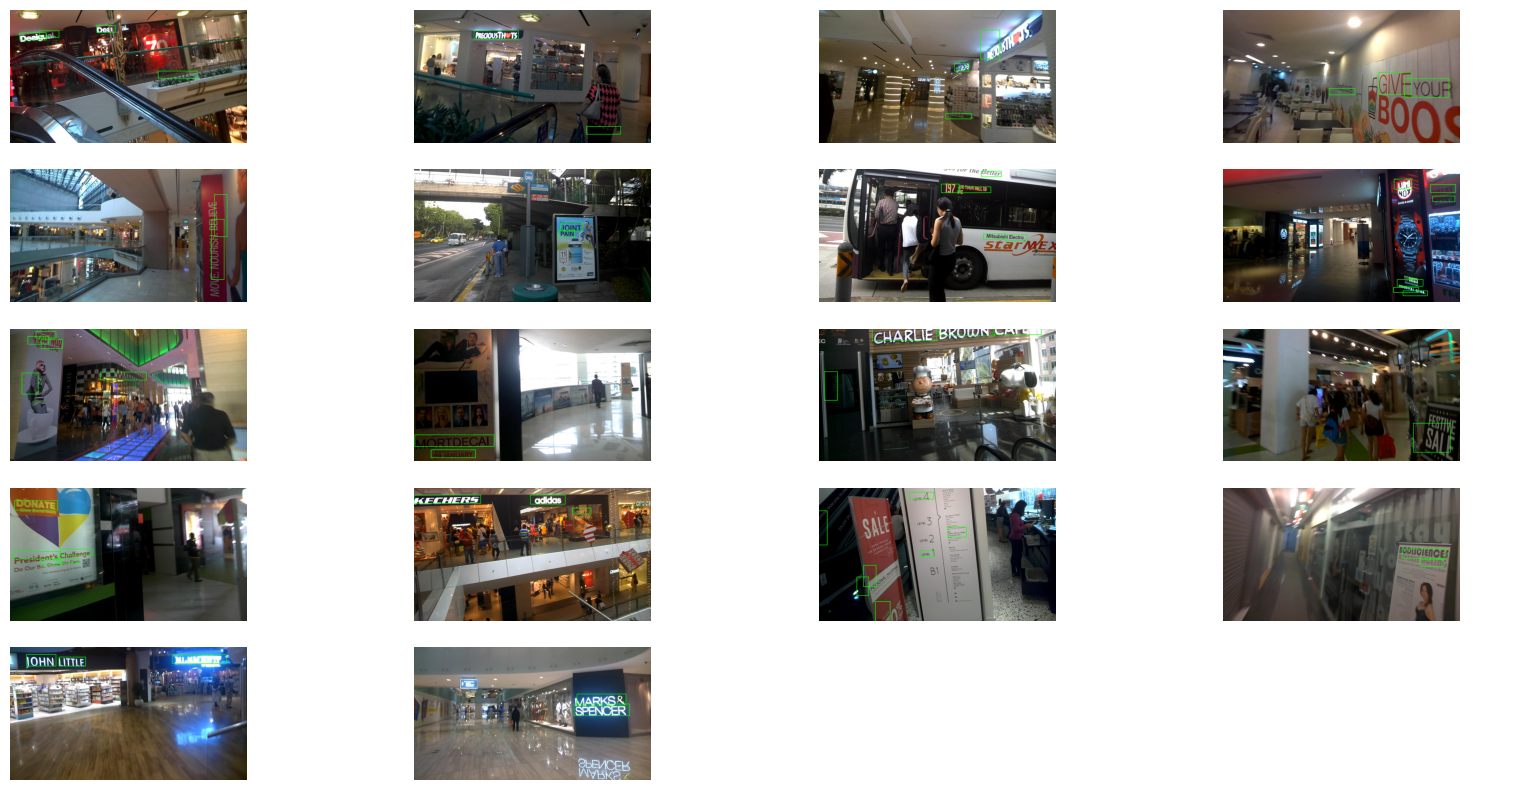

Time taken for text detection on all images: 8.44 seconds


In [36]:
# Performance evaluation
start_time = time.time()

images = []
for filename in os.listdir(input_folder):
    image_path = os.path.join(input_folder, filename)
    annotated_image = detect_and_extract_text(image_path, net, output_folder)
    images.append(annotated_image)

n_images = len(images)
n_cols = min(4, n_images)
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = np.array(axes).reshape(-1)  # Flatten axes for easier indexing

for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for text detection on all images: {elapsed_time:.2f} seconds")
